In [2]:
import numpy as np
from math import sqrt

import datetime
import csv
import matplotlib.pyplot as plt

from pyspark.mllib.clustering import KMeans, KMeansModel
from mpl_toolkits.basemap import Basemap

from scipy import ndimage
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

In [3]:
with open('data/detroit.csv') as f:
    csv_file = csv.reader(f)
    next(csv_file)
    crime_list = []
    for row in csv_file:
        crime_list.append(row)

In [4]:
data = []
for row in crime_list:
    crime_date = datetime.datetime.strptime(row[2], '%m/%d/%Y').date()
    crime_pos  = np.array([float(row[-2]), float(row[-1])])
    crime_type = row[3].split('-')[0].strip()
    crime_type = crime_type.split(',')[0].strip()
    crime_type = crime_type.split('(')[0].strip()
    data.append([crime_date, crime_pos, crime_type])

In [5]:
data_rdd = sc.parallelize(data)
histogram_year_rdd = data_rdd.map(lambda x: (x[0].month, 1)).reduceByKey(lambda x, y: x + y).sortByKey()
year_count = histogram_year_rdd.collect()
histogram_category_rdd = data_rdd.map(lambda x: (x[2], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: -x[1])
category_count = histogram_category_rdd.collect()

<Container object of 12 artists>

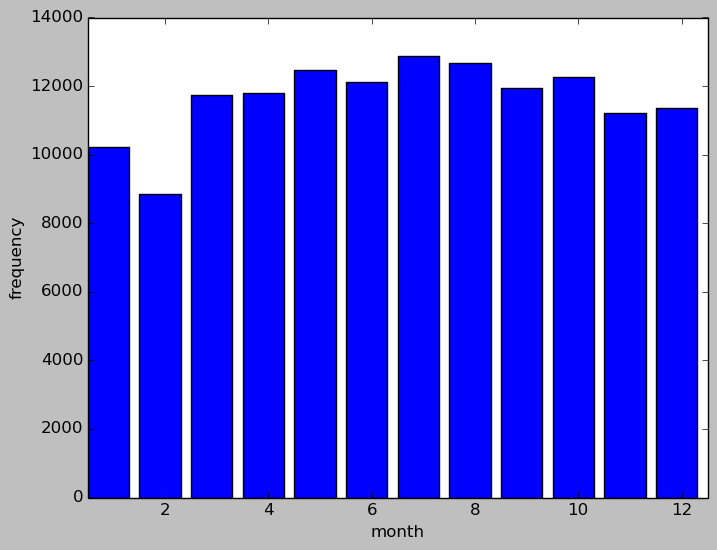

In [6]:
month = [x[0] - 0.5 for x in year_count]
freq = [x[1] for x in year_count]
plt.xlabel('month')
plt.ylabel('frequency')
plt.xlim([0.5,12.5])
plt.bar(month, freq)

<Container object of 211 artists>

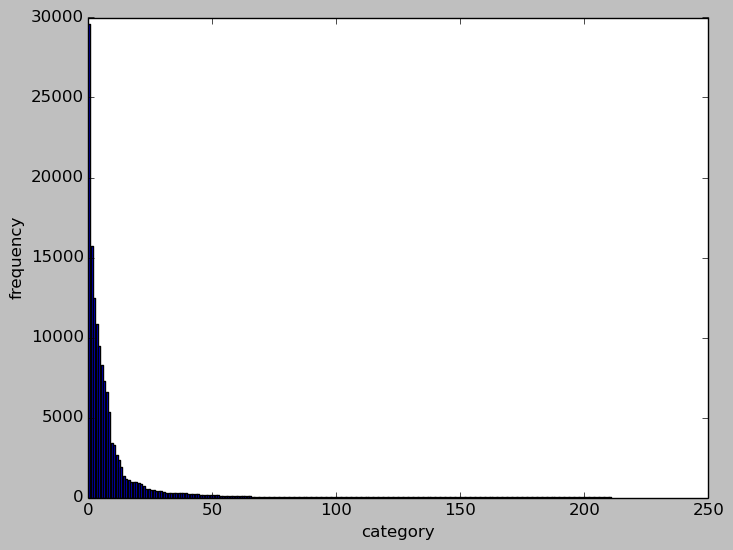

In [7]:
category = [x for x in category_count]
freq = [x[1] for x in category_count]
plt.xlabel('category')
plt.ylabel('frequency')
plt.bar(range(len(category)),freq)

In [8]:
def selection(item, choices):
    return len(choices) == 0 or item in choices

In [9]:
def cluster(date_range, category_types, num_clusters):
    #Label data
    filtered_rdd = data_rdd.filter(lambda x: selection(x[0].month, date_range) and selection(x[2], category_types))
    pos_rdd = filtered_rdd.map(lambda x: x[1])
    clusters = KMeans.train(pos_rdd, num_clusters, maxIterations=100, initializationMode="random")
    label_rdd = pos_rdd.map(lambda x: [x, clusters.centers[clusters.predict(x)]])
    
    #Cluster and distribution
    return label_rdd, clusters

In [10]:
def sse(point, center):
    return sqrt(sum([i**2 for i in (point - center)]))

In [45]:
def danger_rdd(months, categories, num_clusters):
    label, centers = cluster(months, categories, num_clusters)
    center_to_errors= label.map(lambda x: (tuple(x[1]),[sse(x[0],x[1])])).reduceByKey(lambda a,b: a+b)
    #[[center,mean,std,count]...]
    center_info= center_to_errors.map(lambda entry:[entry[0],np.average(entry[1]),np.std(entry[1]),len(entry[1])])
    return center_info

danger_zone = danger_rdd([], [], 15).collect()

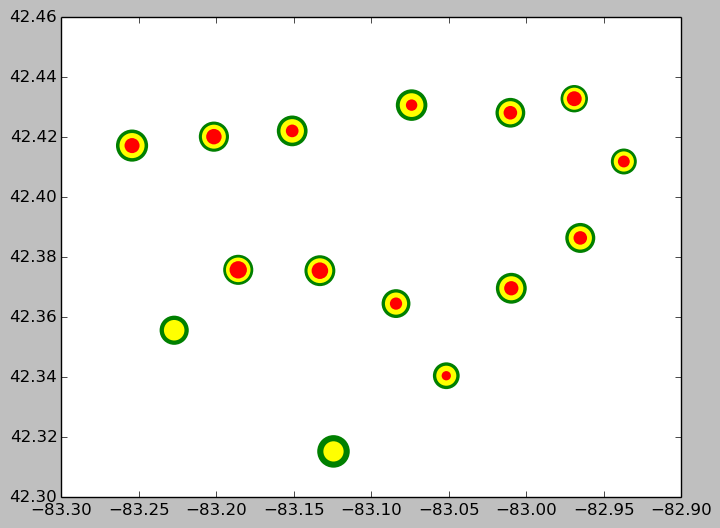

In [101]:
def plot_danger_zone(danger_zone):
    scale = 30000
    danger_zone[0][0]
    colors = ['red', 'yellow', 'green']
    longitudes = [d[0][1] for d in danger_zone]
    latitudes = [d[0][0] for d in danger_zone]
    size_green = [(d[1] * scale) - (d[2] * 0.4 * scale) for d in danger_zone]
    plt.scatter(longitudes, latitudes, s=size_green, c=colors[2], edgecolors='none')
    size_yellow = [(d[1] * scale) - (d[2] * 1.2 * scale) for d in danger_zone]
    plt.scatter(longitudes, latitudes, s=size_yellow, c=colors[1], edgecolors='none')
    size_red = [(d[1] * scale) - (d[2] * 2.0 * scale) for d in danger_zone]
    plt.scatter(longitudes, latitudes, s=size_red, c=colors[0], edgecolors='none')
    plt.show()
plot_danger_zone(danger_zone)

## Plot on simple matplotlib

In [50]:
danger_zone[1]

[(42.420261220133668, -83.201673858712894),
 0.018643082806546109,
 0.007260483295985636,
 12557]

In [ ]:
# scale=1.5

# #for now, only sets markersize ased on count... need to implement blur
# def plot_point(x,y,sd,count):
#     #create marker image
# #     fig2 = plt.figure(2)
# #     fig2.clf()
# #     ax1= fig2.add_subplot(111)
# #     ax1.plot(0.5,0.5,'o',ms=3)
# #     ax1.set_ylim(0,1)
# #     ax1.set_xlim(0,1)
# #     plt.axis('off')
# #     fig2.savefig('marker.png', dpi=10)
    
# #     print("made figure")
    
# #     #plot with Gaussian blur
# #     plt.figure(1)
# #     #marker = plt.imread('marker.png')
# #     markerBlur = ndimage.gaussian_filter(marker,sd)
# #     # Create an BboxImage for the blurred marker and add it to the plot. 
# #     bb = Bbox.from_bounds(x,y,1,1)  
# #     bb2 = TransformedBbox(bb,ax1.transData)
# #     bbox_image = BboxImage(bb2,
# #                            norm = None,
# #                            origin=None,
# #                            clip_on=False)
# #     bbox_image.set_data(markerBlur)
# #     print("s")
# #     ax1.add_artist(bbox_image)
#     lats=[x]
#     lons=[y]
#     x,y = map(lons, lats)
#     map.plot(x, y, 'bo', markersize=scale*count)

In [ ]:
# detroit_long= -82.928223
# detroit_lat= 42.405678


# fig1=plt.figure(1)
# ax1=fig1.add_subplot(111)
# map = Basemap(projection='merc', lat_0 = detroit_lat, lon_0 = detroit_long,
#     resolution = 'f',
#     llcrnrlon=-83.35, llcrnrlat=42.28,
#     urcrnrlon=-82.81, urcrnrlat=42.48)
 
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')
# map.drawcoastlines()
# map.drawstates()
# map.drawparallels([x/100.0 for x in range(4210, 4265, 5)], linewidth=1.0, dashes=[4, 2], labels=[1,0,0,0], color='r')
# map.drawmeridians([x/100.0 for x in range(-8330, -8285, 5)], labels=[1,0,0,0])

# ###fixed marker size
# #lats=[x[0] for x in centers]
# #lons=[x[1] for x in centers]
# #x,y = map(lons, lats)
# #map.plot(x, y, 'bo', markersize=10)

# #plot all centers with varying marker size
# for entry in danger_zone:
#     plot_point(entry[0][0], entry[0][1], entry[2], entry[3])

# plt.show()

In [ ]:
category_count